# Advanced Machine Learning: Assignment 1

Nome e cognome: Confalonieri Riccardo <br>
Matricola: 830404<br>
E-mail: r.confalonieri5@campus.unimib.it

# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 

## Import packages

In [196]:
# for mounting GDrive
from google.colab import drive

# dataset handling
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for splitting dataset
from sklearn.model_selection import train_test_split


# for preprocessing. Normalizing variables
from sklearn.preprocessing import StandardScaler

# for concatenate numpy array
import numpy as np

# for upsampling/downsampling datataset
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample

# for shuffle dataset
from sklearn.utils import shuffle

# for neural network
from keras.models import Sequential
# importing keras layers for the model (dropout per regularization)
from keras.layers.core import Dense, Activation, Dropout
# for model optimizer
from tensorflow.keras.optimizers import SGD
# regularization
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
# for model plot
from keras.utils.vis_utils import plot_model

# For evaluate classification 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

## Loading data
In questa sezione carico i dataset contenenti tutti i dati necessari. Per il caricamento mi avvalgo del collegamento a Google Drive per evitare di importare i singoli file in un path locale.

In [10]:
# mount personal gdrive folder
drive.mount('/content/drive')

# define data folder path
drive_path = '/content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment1/Dati/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Loading dataset contains all features
df_X_train = pd.read_csv(drive_path + 'X_train.csv')
# display first 5 row
df_X_train.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,21754,80000.0,2,2,2,24,0,0,0,0,0,0,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
1,252,30000.0,1,2,2,28,0,0,0,0,0,0,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
2,22942,180000.0,2,5,1,44,0,0,-1,-1,-1,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
3,619,60000.0,1,1,2,25,0,0,0,0,0,0,58839.0,53235.0,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
4,17091,130000.0,2,2,2,25,0,0,0,0,0,0,111587.0,112348.0,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0


In [12]:
# Loading dataset contains the variabile to predict
df_Y_train = pd.read_csv(drive_path + 'y_train.csv')
# display first 5 row
df_Y_train.head()

,ID,default.payment.next.month
0,21754,0
1,252,0
2,22942,0
3,619,0
4,17091,0


In [13]:
# renaming default column in Y train dataset
df_Y_train = df_Y_train.rename(columns={df_Y_train.columns[1]: 'DEFAULT'})

In [14]:
# Merge the two dataset on ID column
df_train = pd.merge(df_X_train, df_Y_train, on="ID")
# removing unnecessary column ID
df_train.drop('ID', axis = 1, inplace = True)
# display first 5 row
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,80000.0,2,2,2,24,0,0,0,0,0,0,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0,0
1,30000.0,1,2,2,28,0,0,0,0,0,0,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0,0
2,180000.0,2,5,1,44,0,0,-1,-1,-1,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0,0
3,60000.0,1,1,2,25,0,0,0,0,0,0,58839.0,53235.0,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0,0
4,130000.0,2,2,2,25,0,0,0,0,0,0,111587.0,112348.0,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0,0


In [15]:
# Loading dataset containing features to predict output variable with models
# I will not use this dataset until the last section (prediction) of this notebook
df_test = pd.read_csv(drive_path + 'X_test.csv')
# display first 5 row
df_test.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2309,30000.0,1,2,2,25,0,0,0,0,0,0,8864.0,10062.0,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
1,22405,150000.0,2,1,2,26,0,0,0,0,0,0,136736.0,125651.0,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
2,23398,70000.0,2,3,1,32,0,0,0,0,0,0,70122.0,69080.0,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
3,25059,130000.0,1,3,2,49,0,0,0,0,0,-1,20678.0,18956.0,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
4,2665,50000.0,2,2,2,36,0,0,0,0,0,2,94228.0,47635.0,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0


## Inspecting the data
In questa sezione analizzero i dataset appena caricati cercando di capire eventuali punti deboli e/o eventuali preprocessing necessari.

### General analysis

In [12]:
# General information about number of rows and columns
print("Dataset shape" + str(df_train.shape))

Dataset shape(24000, 24)


In [13]:
# checking null values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_0      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PAY_AM

Il dataset non contiene *nessun valore nullo*, quindi in questo caso non è necessario attuare nessuna azione specifica in questo senso. La stessa cosa è verificabile sul dataset di test che verrà utilizzato nel proseguo del notebook. <br>
Procedo iniziando a visualizzare alcune informazioni sulle *variabili categoriche*. Si potrebbero considerare come categoriche anche le variabili `PAY_X`, tuttavia dai test effettuati si è visto che non influiscono in positivo sul modello ma anzi ne aumentano la complessità perchè richiedono 8 dummy ciascuna. (Nota: dato che assumono anche valori negativi andrebbero prima rimappate in un nuovo range [0,10])

In [14]:
# general analysis of categorical variables. Checking if min/max correspond to specifics
categorical_col = ['SEX', 'EDUCATION', 'MARRIAGE'] #, 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
quantitative_col = df_train.columns.difference(categorical_col + ['DEFAULT'])
df_train[categorical_col].describe()

,SEX,EDUCATION,MARRIAGE
count,24000.000000,24000.000000,24000.000000
mean,1.604917,1.854000,1.551417
std,0.488879,0.792176,0.522766
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


Da quest'analisi risultano alcune criticità che vanno gestite:


1.   **Education**: assume come valori anche 0, inoltre tutti i valori >4 possono essere accorpati sotto la label '4' che indica la non conoscenza dello stato.
2.   **Marriage**: assume come valore anche lo 0, anche in questo caso non è previsto dalle specifiche e lo si può accorpare alla label '3' che indica anche in questo caso la non conoscenza.



### Is the class balanced? 
Controllo se la classe che voglio predire è bilanciata oppure una delle due classi è preponderante.

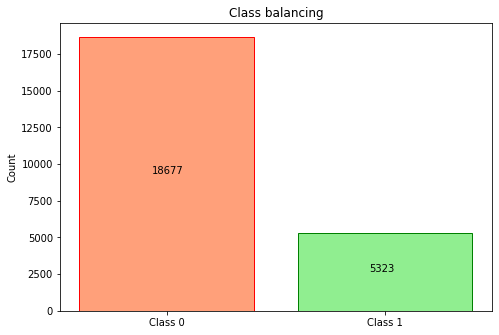

In [15]:
# Get class balancing
bal = df_train['DEFAULT'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Class 0', 'Class 1']
ax.bar(langs, [bal[0], bal[1]], 
       color=["lightsalmon", "lightgreen"],  edgecolor=['red', 'green'])
ax.set_title('Class balancing')
ax.set_ylabel('Count')

# print value in bar
for pos, val in zip([0,1], bal):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()

Dal grafico risulta evidente che le due classi *non sono bilanciate* e che la classe 1 è presente circa 4 volte la classe 0. Questo problema andrà sicuramente risolto prima di passare i dati al modello.

### Data correlation
Verifico se e come sono correlate le variabili nel dataset.

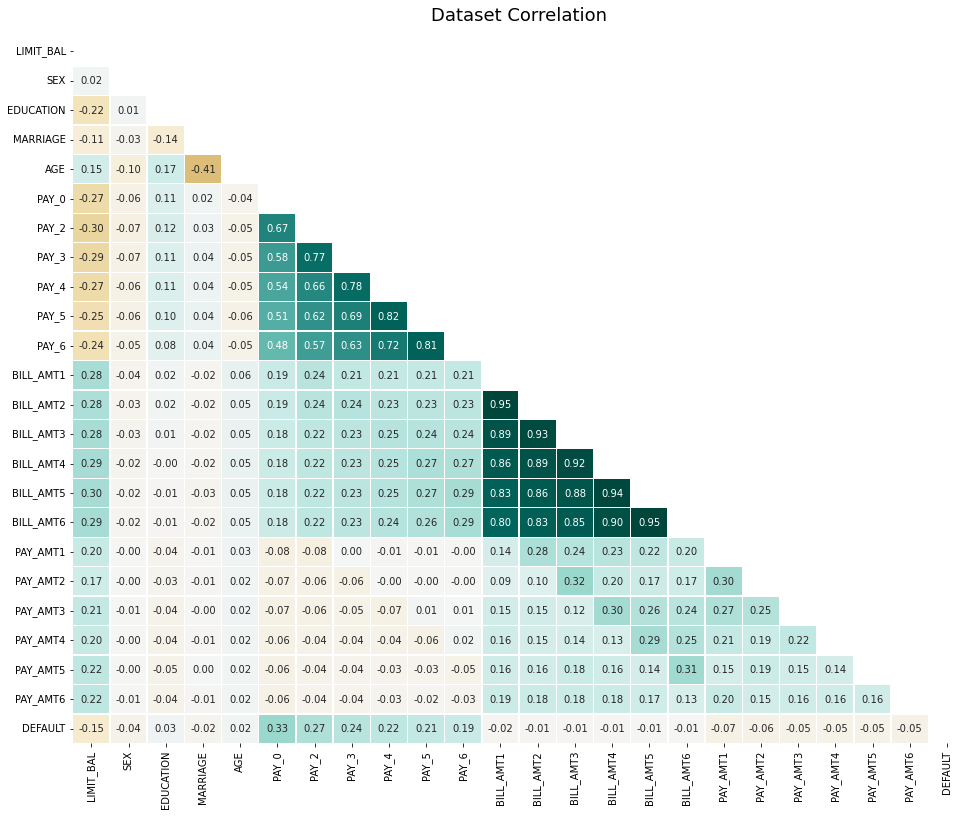

In [16]:
plt.figure(figsize=(16, 13))# define the mask to set the values in the upper triangle to True
cm = df_train.corr()
mask = np.triu(np.ones_like(cm, dtype=np.bool))
heatmap = sns.heatmap(cm, mask=mask, annot=True, cmap='BrBG', vmin = -1, 
                      vmax = 1, cbar = False, linewidths = .3, fmt='.2f')
heatmap.set_title('Dataset Correlation', fontdict={'fontsize':18}, pad=16);

Dalla matrice triangolare di correlazione visualizata sopra risulta evidente come le variabili `PAY_X` siano fortemente correlate tra loro, lo stesso per le variabili `BILL_AMTX` mentre la correlazione tra le altre variabili non sembra essere così forte. <br>
Potrebbe essere quindi utili provare ad effettuare una PCA o tentare di trasformare queste variabili in un nuovo spazio per migliorare il modello.

### Data distribution
Provo a plottare un grafico basilare per verificare la distribuzione delle variabili nel dataset.

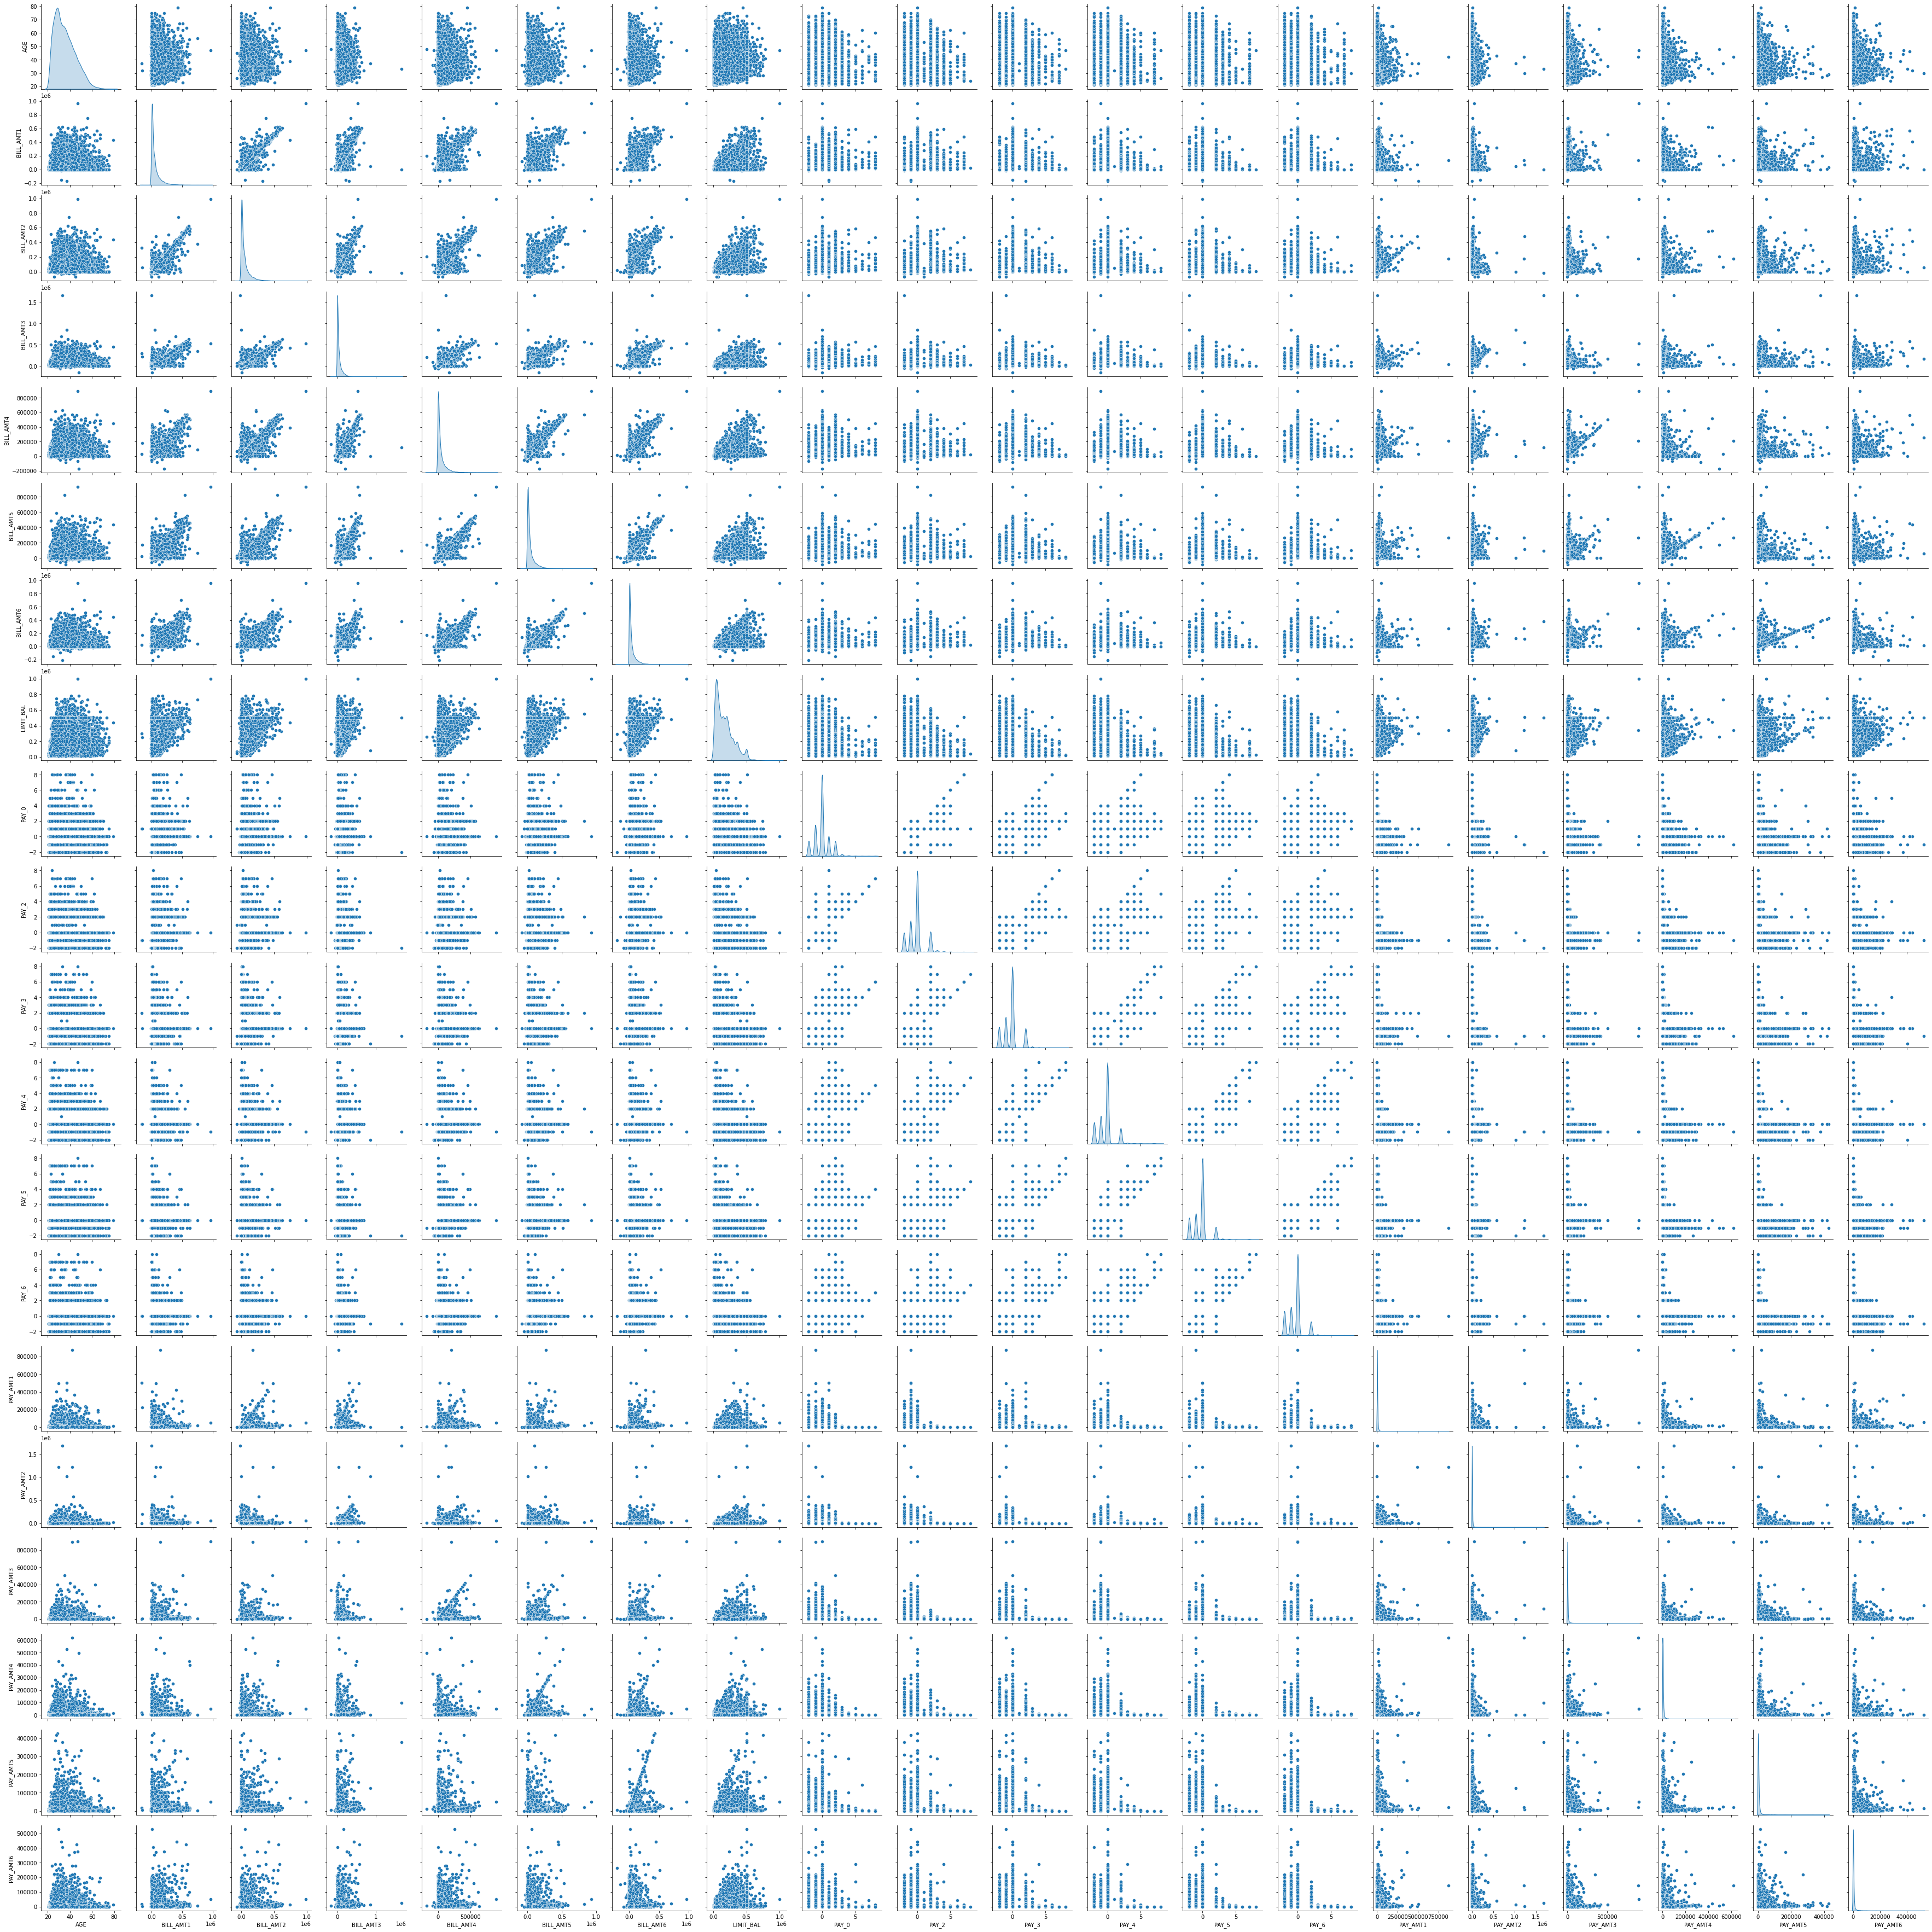

In [17]:
# it requires a very long long execution!!
sns.pairplot(df_train.loc[:, quantitative_col], diag_kind="kde")

Dal grafico si evidenzia che le variabili hanno tutte una *coda destra*.

## Preprocessing
In questa sezione mi occuperò di gestire le problematiche evidenziate dall'analisi del dataset in modo da ottenere un ''nuovo'' dataset pronto per essere passato al modello neurale. Ho deciso di implementare delle funzioni per la gestione del preprocessing in modo che siano generiche e possano essere facilmente applicate anche a nuovi dati (df_test) su cui vogliamo predire la variabile di `DEFAULT`.


In [16]:
# get default column
Y = df_train['DEFAULT']

# removing default column to the dataset
df_train.drop('DEFAULT', axis = 1, inplace = True)

### Categorical variables
Per prima cosa *gestisco i valori* che non dovrebbero essere presenti in alcune variabili categoriche sostituendole con quelle opportune.

In [17]:
def replace_education_values(df):
  # replace the values 5, 6 and 0 of EDUCATION variable with the generic value 4 
  mask = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
  df.loc[mask, 'EDUCATION'] = 4

def replace_marriage_values(df):
  # replace the values 0 of MARRIAGE variable with the generic value 3
  mask = (df.MARRIAGE == 0)
  df.loc[mask, 'MARRIAGE'] = 3

In [20]:
# replace education values
replace_education_values(df_train)
# replace marriage values
replace_marriage_values(df_train)

# checking if is ok now
df_train[['EDUCATION', 'MARRIAGE']].describe()

,EDUCATION,MARRIAGE
count,24000.000000,24000.000000
mean,1.842750,1.557042
std,0.745629,0.522182
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,4.000000,3.000000


Una volta corretti i problemi nei valori *creo le dummy corrispondenti* a tutte le variabili categoriche. In particolar modo creo $n-1$ variabili dummy in questo modo evito che si crei *collinearità* tra le dummy. <br>
Come già descritto si è deciso di **non includere** nelle variabili categoriche le `PAY_X` in quanto aumentano di molto la complessità del modello senza apportare benefici.

In [21]:
def dummy_creation(df_categorical):
  # converting categorical values to n-1 dummy variables
  df_dummy = pd.get_dummies(data = df_categorical, drop_first = True, 
                            columns = df_categorical.columns)
  return df_dummy

# get sub dataset with only categorical variabiles (without default coloumn)
df_train_categorical = df_train[categorical_col]
# create df with dummy variables
df_dummy = dummy_creation(df_train_categorical)
df_dummy.head()

,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,1,1,0,0,1,0
1,0,1,0,0,1,0
2,1,0,0,1,0,0
3,0,0,0,0,1,0
4,1,1,0,0,1,0


Una volta creato il dataframe contenente le variabili dummy elimino dal vecchio dataframe le variabili categoriche sostituendole con le corrispondenti nuove dummy.

In [22]:
# add dummy columns to the dataframe and delete the old column

# drop the old categorical columns from dataset
df_train.drop(categorical_col, axis = 1, inplace=True)
# concat dataset with dummy dataset
df_train = pd.concat([df_train, df_dummy], axis = 1)
# check result
df_train

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_2,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_2,MARRIAGE_3
0,80000.0,24,0,0,0,0,0,0,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0,1,1,0,0,1,0
1,30000.0,28,0,0,0,0,0,0,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0,0,1,0,0,1,0
2,180000.0,44,0,0,-1,-1,-1,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0,1,0,0,1,0,0
3,60000.0,25,0,0,0,0,0,0,58839.0,53235.0,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0,0,0,0,0,1,0
4,130000.0,25,0,0,0,0,0,0,111587.0,112348.0,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,50000.0,32,0,0,0,0,0,0,52475.0,53600.0,55739.0,55957.0,29238.0,6119.0,2000.0,3000.0,1591.0,72.0,1134.0,73421.0,0,1,0,0,1,0
23996,200000.0,37,2,2,2,2,2,2,157131.0,166590.0,168386.0,164182.0,169029.0,172084.0,13500.0,6000.0,0.0,7500.0,6000.0,4000.0,0,0,0,0,1,0
23997,50000.0,26,-2,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
23998,70000.0,25,0,0,0,0,2,2,73939.0,70488.0,51152.0,35122.0,28633.0,28039.0,3000.0,2000.0,4500.0,1200.0,0.0,1200.0,1,1,0,0,1,0


### Preparing data for balancing
Per bilanciare i dati è meglio prima effettuare lo splitting del dataset in training e test set. In questo modo quando andrò a testare il modello sul test set per valutarne le metriche avrò dei risultati il più possibile vicini a quelli del mondo reale.

In [23]:
# Splitting into train and test 
X_train, X_test, Y_train, Y_test = train_test_split(df_train, Y, test_size = 0.1,
                                                    random_state=99)

### Downsampling approach
Visto che le due classi sono fortemente sbilanciate, decido di applicare come prima opzione la procedura del downsampling per ottenere un bilanciamento più opportuno. Per non eliminare completamente lo sbilanciamento decido di mantenere il $10\%$ in più di istanze per la classe maggiormente presente, la 0.
Una volta effettuato il downsampling estraggo anche la colonna `DEFAULT` che non necessita di ulteriori preprocessing in quanto è quella che vogliamo arrivare a predire e contiene soltanto le classi binarie.

In [24]:
# rechecking unbalancing after splitting
print("Distribution:\n", Y_train.value_counts())

Distribution:
 0    16785
1     4815
Name: DEFAULT, dtype: int64


In [25]:
# Let's downsample

# append the default column to x_train dataset, to simplify resizing 
# they will split again later
df_temp = pd.concat([X_train, Y_train], axis = 1)

# get all rows with default = 1
df_minor = df_temp[df_temp['DEFAULT']==1.0]
# get all rows with default = 0
df_major = df_temp[df_temp['DEFAULT']==0.0]

# get the number of sample for the minority class
size_minor_class = len(df_minor)
# compute the desidered new size for the major class
size_majority_class = int(size_minor_class + size_minor_class*10/100)

# extracting N random rows without replacement (= indipendent rows)
# N is exactly the number of rows I want to get balanced dataset
df_major = resample(df_major, replace=False,
                    n_samples=size_majority_class,   
                    random_state=123)

In [26]:
# combining the two dataset to get the final one for the model
X_train_downsample = pd.concat([df_minor, df_major], axis = 0)

# Shuffle rows, otherwise all default = 1 will be the first K rows
X_train_downsample = shuffle(X_train_downsample)

# splitting again features variables and target variable
Y_train_downsample = X_train_downsample['DEFAULT']
X_train_downsample = X_train_downsample.loc[:, X_train_downsample.columns != 'DEFAULT']

In [27]:
# check if now the two class are balanced
print("Distribution:\n", Y_train_downsample.value_counts())

Distribution:
 0    5296
1    4815
Name: DEFAULT, dtype: int64


### Upsampling (SMOTE) approach
In questo caso provo ad riscalare la classe minore aumentandone il numero di campioni con la tecnica SMOTE. Successivamente creerò modelli diversi, uno con il dataset con downsample e un modello con upsample. <br>
Per confrontare i due modelli nel modo migliore utilizzo gli stessi X_train e Y_train utilizzati nell'approccio di downscaling. In questo modo i dati a disposizione dei due modelli non saranno falsati da eventuali splitting diversi.

In [114]:
# get the function for smooting
oversample = SMOTE()
# oversampling the model
X_train_upsample, Y_train_upsample = oversample.fit_resample(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
# check if now the two label are balanced
counter = Counter(Y_train_upsample)
print(counter)

Counter({1: 16785, 0: 16785})


In [ ]:
temp_df = np.concatenate((X_train_upsample, 
                          Y_train_upsample.reshape(len(Y_train_upsample), 1)), 
                         axis = 1)
np.random.shuffle(temp_df)

X_train_upsample = temp_df[:, 0:26]
Y_train_upsample = temp_df[:, 26:27]

### Upsampling (random) approach
Oltre all'approccio di smote per l'upsampling dei dati provo ad usare una strategia random simile a quella utilizzata per il downsampling, in questo caso però ogni singola istanza potrà essere presa più volte tramite replacement.

In [81]:
# Let's downsample

# append the default column to x_train dataset, to simplify resizing 
# they will split again later
df_temp = pd.concat([X_train, Y_train], axis = 1)

# get all rows with default = 1
df_minor = df_temp[df_temp['DEFAULT']==1.0]
# get all rows with default = 0
df_major = df_temp[df_temp['DEFAULT']==0.0]

# compute the desidered new size for the minority class
size_majority_class = len(df_major)

# extracting N random rows without replacement (= indipendent rows)
# N is exactly the number of rows I want to get balanced dataset
df_minor = resample(df_minor, replace=True,
                    n_samples=size_majority_class,   
                    random_state=123)

In [82]:
# combining the two dataset to get the final one for the model
X_train_upsample_rnd = pd.concat([df_minor, df_major], axis = 0)

# Shuffle rows, otherwise all default = 1 will be the first K rows
X_train_upsample_rnd = shuffle(X_train_upsample_rnd)

# splitting again features variables and target variable
Y_train_upsample_rnd = X_train_upsample_rnd['DEFAULT']
X_train_upsample_rnd = X_train_upsample_rnd.loc[:, X_train_upsample_rnd.columns != 'DEFAULT']

In [83]:
# check if now the two class are balanced
print("Distribution:\n", Y_train_upsample_rnd.value_counts())

Distribution:
 1    16785
0    16785
Name: DEFAULT, dtype: int64


### Normalizing distribution
Dato che nell'analisi del dataset si era evidenziata una coda a destra per tutte le variabili applico una standardizzazione per uniformarne la distribuzione approssimandola a quella di una normale con media $ \mu = 0$ e varianza $ \sigma^2 = 1$. <br>
Applico lo stesso tipo di normalizzazione sia per il dataset ridotto con downscaling sia per quello in cui è stata applicata la tecnica di SMOTE.

In [30]:
def scaling_variable(df, scaler = None):
  # this function apply normalization to variables. return standardized df and the scaler.
  # by re-using the returned scaler it's possible to apply the same 
  # trasformation to the df_test for prediction

  if not scaler:
    # getting new scaler
    scaler = StandardScaler()
    # fitting input dataframe
    scaler.fit(df)

  # normalizing variables
  normalized_df = scaler.transform(df)

  return normalized_df, scaler

# normalizing downsampled dataset
X_train_downsample = X_train_downsample.astype('float32')
X_train_downsample, train_scaler = scaling_variable(X_train_downsample)

# normalizing upsample dataset with the same scaler
X_train_upsample = X_train_upsample.astype('float32')
X_train_upsample, _ = scaling_variable(X_train_upsample, train_scaler)

# normalizing upsample dataset with the same scaler
X_train_upsample_rnd = X_train_upsample_rnd.astype('float32')
X_train_upsample_rnd, _ = scaling_variable(X_train_upsample_rnd, train_scaler)

# normalizing the test subset with the same scaler
X_test, _  = scaling_variable(X_test, train_scaler)

## Feed forward neural network
In questa sezione racchiudo i metodi utili per l'implementazione e l'analisi di modelli feed-forward neural network. Ho deciso di implementare delle funzioni per evitare di riscrivere lo stesso codice varie volte per i diversi modelli.

Il primo metodo implementato è quello per construire un modello FFNN, il **modello riportato è stato selezionato** alla fine di diverse prove dopo le quali è risultato il migliore. In particolare sono stati fatti **diversi tentativi** con numero di layer e neuroni diversi ma anche con funzioni di attivazione (leaky_relu, PReLU) e ottimizzazione (Adam, SGD con learning rate minore) diverse.

In [199]:
# method for create a ffnn model
def build_ffnn_model(layer_dim, dropout = None):
  # layer_dim dimension of layer
  # dropout: None or array with percentage of dropout for second and third layer


  # For a single-input model with 2 classes (binary classification):
  model = Sequential()

  # FC @ 32, non linear
  model.add(Dense(32, activation = "relu", input_shape=(layer_dim,)))
  # FC @ 16, non linear
  model.add(Dense(16, activation = "relu"))
    # if present add dropout layer
  if dropout is not None:
    model.add(Dropout(dropout[0]))
  # FC @ 8, non linear
  model.add(Dense(8, activation = "relu"))
  # if present add dropout layer
  if dropout is not None:
    model.add(Dropout(dropout[1]))

  # output layer (1)
  # uso 1 come numero di classi da predire perchè è un caso particolare che 
  # funziona solo con predizioni su classi binarie, altrimenti dovevo mettere esattamente il # di classi
  model.add(Dense(1, activation="sigmoid"))

  # compile: optimizer & losses/metrics
  model.compile(optimizer = SGD(), loss = "binary_crossentropy", 
                metrics = ["accuracy"])
  
  return model

In [195]:
dropout = 0.3
if dropout is not None:
  print("ciao")

ciao


La seconda funzione è quella che permette di traninare il modello, in questo caso si sono effettaute diverse scelte:


*   **Early_stopping**: Ho deciso di introdurre questa tecnica di regolarizzazione perchè altrimenti i modelli overfittavano troppo i dati di traning, inoltre in questo modo posso aumentare il numero di epoche senza preoccuparmi di modificarle per ogni singolo traning set diverso creato.
* Utilizzo di un **validation_set**: questo viene utilizzato per stoppare il traning nel caso di involuzioni nella loss attraverso l'early_stopping. 
*   Numero di epoche alto: questo non risulta essere un problema grazie all'early_stopping



In [57]:
def training_ffnn(model, X_train, Y_train, early_stopping = None, 
                  n_epochs = 100, batch_size = 64, validation_size = 0.1):
  
  # fitting the model based on parameters
  history = model.fit(X_train, Y_train, epochs = n_epochs, 
                      batch_size = batch_size, verbose = 2, 
                      validation_split=validation_size, 
                      callbacks=[early_stopping])
  
  return history

La seguente è una funzione che permette di plottare i valori di loss e accuray estratti dala storia del modello per verificare eventuali problemi di under/overfitting.

In [34]:
# plot training history
def plot_history(network_history):
    plt.figure(figsize = (13, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('model loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize = (13, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('model accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

L'ultima funzione permette invece di utilizzare il modello per prevedere nuovi dati e valutare la predizione con alcune metriche.

In [160]:
def evaluate_predition_ffnn(model, df_X, df_Y):
  y_pred = model.predict(df_X)
  y_pred = (y_pred > 0.5)

  cm = confusion_matrix(df_Y, y_pred)

  cl = classification_report(df_Y, y_pred, output_dict=True) 
  print('\nClassification Report\n', classification_report(df_Y, y_pred))

  ax = plt.subplot()
  #annot=True to annotate cells, ftm='g' to disable scientific notation
  sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu");  

  ax.set_xlabel('True labels'); ax.set_ylabel('Predicted labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['No default', 'Default']); 
  ax.yaxis.set_ticklabels(['No default', 'Default']);

  return y_pred, cl

## More consideration about test set
Si è deciso di implementare sia un test set sia un validation set questo per diversi motivi. 
In primo luogo il **validation set** sarà utilizzato per *stoppare il traning del modello* prevendo eventuali overfitting grazie alla tecnica di early_stopping. Tuttavia questo validation set è estratto dai dati di traning che sono stati ribilanciati e quindi <i>"lontani" dal mondo reale<i/> e quindi non sarebbe ideale per la valutazione delle metriche del modello, in tal senso viene utilizzato il **test set** che è invece stato estratto prima del ribilanciamento e quindi *mantiene lo sbilanciamento* sulla classe `DEFAULT` come ci si aspetta che avvenga anche nel *mondo reale* e quindi con dati mai visti.

## Downsample model
Questo modello utilizza i dati "creati" con la tecnica di downsample. I parametri di configurazione di questo modello saranno gli stessi che verranno utilizzati nei successivi modelli. <br>

In [35]:
# build the model
model_downsample = build_ffnn_model(X_train_downsample.shape[1])

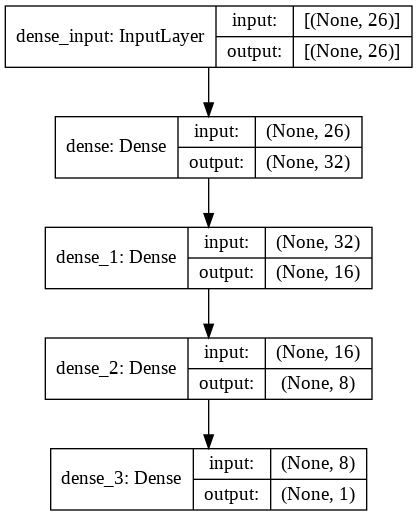

In [190]:
# plotting the model
plot_model(model_downsample, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
# early stopping method
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, min_delta = 0.001, 
                   mode='min', restore_best_weights=True)

# training the model
history_mod_downsample = training_ffnn(model_downsample, X_train_downsample,
                                       Y_train_downsample, es)

Epoch 1/100
143/143 - 2s - loss: 0.6690 - accuracy: 0.5803 - val_loss: 0.6520 - val_accuracy: 0.6304
Epoch 2/100
143/143 - 0s - loss: 0.6471 - accuracy: 0.6372 - val_loss: 0.6348 - val_accuracy: 0.6453
Epoch 3/100
143/143 - 0s - loss: 0.6341 - accuracy: 0.6503 - val_loss: 0.6229 - val_accuracy: 0.6571
Epoch 4/100
143/143 - 0s - loss: 0.6254 - accuracy: 0.6590 - val_loss: 0.6148 - val_accuracy: 0.6729
Epoch 5/100
143/143 - 0s - loss: 0.6189 - accuracy: 0.6674 - val_loss: 0.6091 - val_accuracy: 0.6798
Epoch 6/100
143/143 - 0s - loss: 0.6137 - accuracy: 0.6747 - val_loss: 0.6050 - val_accuracy: 0.6848
Epoch 7/100
143/143 - 0s - loss: 0.6095 - accuracy: 0.6790 - val_loss: 0.6000 - val_accuracy: 0.6887
Epoch 8/100
143/143 - 0s - loss: 0.6057 - accuracy: 0.6821 - val_loss: 0.5964 - val_accuracy: 0.6897
Epoch 9/100
143/143 - 0s - loss: 0.6026 - accuracy: 0.6859 - val_loss: 0.5937 - val_accuracy: 0.6917
Epoch 10/100
143/143 - 0s - loss: 0.5997 - accuracy: 0.6890 - val_loss: 0.5913 - val_accura

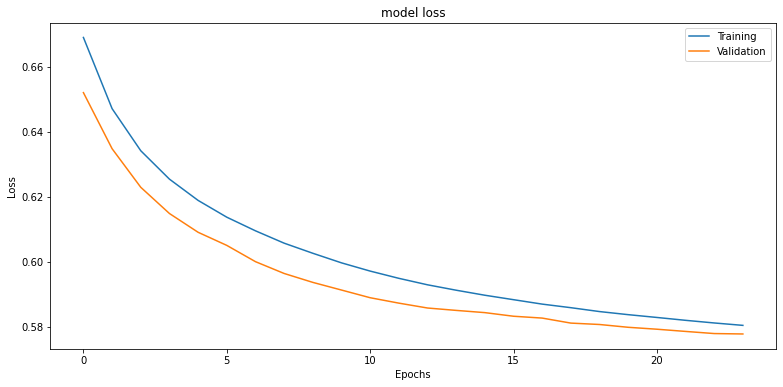

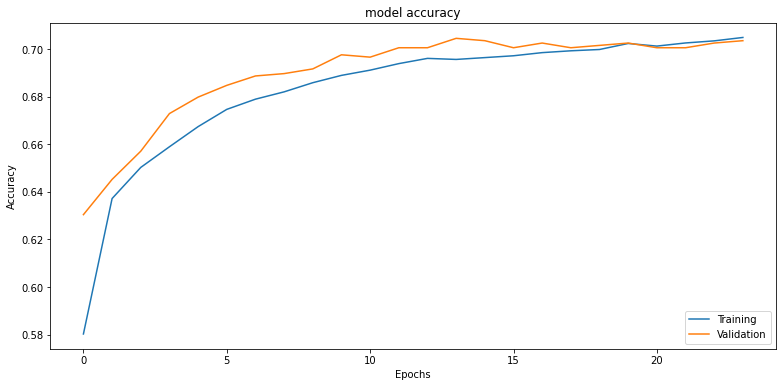

In [37]:
plot_history(history_mod_downsample)

Dai grafici appena riportati si nota che il validation set segue l'andamento del traning set sia per la loss che per l'accuracy. In particolare si segnale un **underfitting del modello molto leggero** nella loss, in tal senso si è provato a complicare e modificare il modello per migliorarlo senza ottenere risultati particolarmente migliori.

### Testing downsample model
Valuto il modello sfruttando il test set.


Classification Report
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1892
           1       0.51      0.57      0.54       508

    accuracy                           0.79      2400
   macro avg       0.70      0.71      0.70      2400
weighted avg       0.80      0.79      0.80      2400



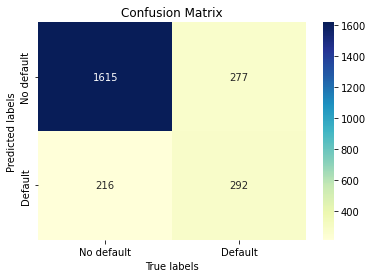

In [161]:
y_pred_downsample, cl_downsample = evaluate_predition_ffnn(model_downsample, 
                                                           X_test, Y_test)

Dai risultati si evidenzia come il modello sia molto valido nel prevedere la classe 0 mentre nella classe 1 la precisione scende molto, nello specifico per la classe 1 (quella di probabile maggior interesse per noi) si ha una percentuale circa del 50\% nella previsione dei dati.

## Upsample model

In [107]:
# build the model
model_upsample = build_ffnn_model(X_train_upsample.shape[1])

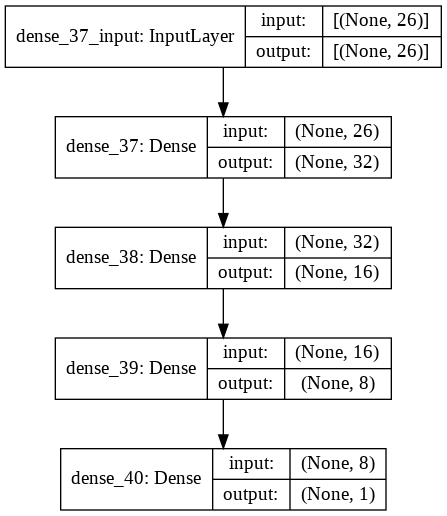

In [191]:
# plotting the model
plot_model(model_upsample, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [108]:
# same configuration as before 
history_mod_upsample = training_ffnn(model_upsample, X_train_upsample, 
                                     Y_train_upsample, es)

Epoch 1/100
473/473 - 2s - loss: 0.6624 - accuracy: 0.6113 - val_loss: 0.6297 - val_accuracy: 0.6598
Epoch 2/100
473/473 - 1s - loss: 0.6128 - accuracy: 0.6860 - val_loss: 0.6058 - val_accuracy: 0.6842
Epoch 3/100
473/473 - 1s - loss: 0.5928 - accuracy: 0.7048 - val_loss: 0.5942 - val_accuracy: 0.6965
Epoch 4/100
473/473 - 1s - loss: 0.5791 - accuracy: 0.7172 - val_loss: 0.5830 - val_accuracy: 0.7137
Epoch 5/100
473/473 - 1s - loss: 0.5697 - accuracy: 0.7237 - val_loss: 0.5777 - val_accuracy: 0.7146
Epoch 6/100
473/473 - 1s - loss: 0.5633 - accuracy: 0.7292 - val_loss: 0.5774 - val_accuracy: 0.7143
Epoch 7/100
473/473 - 1s - loss: 0.5581 - accuracy: 0.7307 - val_loss: 0.5695 - val_accuracy: 0.7221
Epoch 8/100
473/473 - 1s - loss: 0.5531 - accuracy: 0.7347 - val_loss: 0.5646 - val_accuracy: 0.7245
Epoch 9/100
473/473 - 1s - loss: 0.5484 - accuracy: 0.7378 - val_loss: 0.5604 - val_accuracy: 0.7319
Epoch 10/100
473/473 - 1s - loss: 0.5440 - accuracy: 0.7423 - val_loss: 0.5597 - val_accura

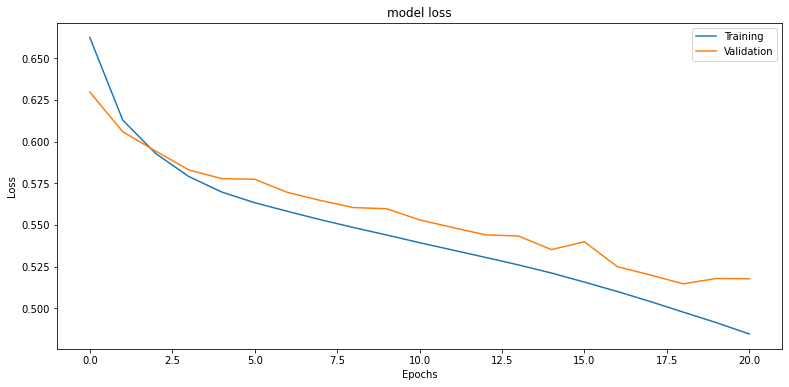

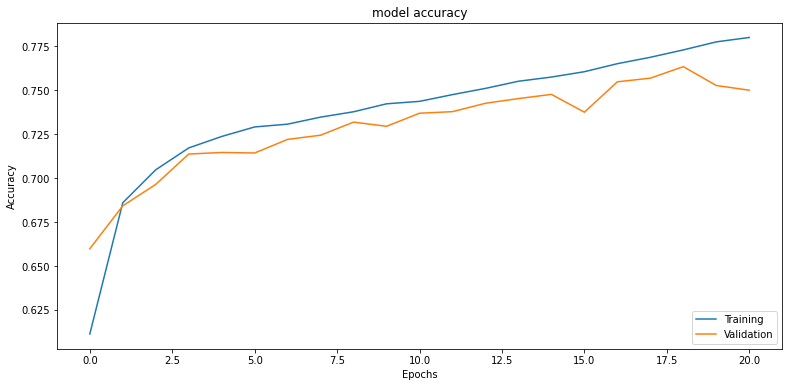

In [110]:
plot_history(history_mod_upsample)

A differenza del modello precedente in questo caso siamo davanti ad un **leggero overfitting** dei dati che però appunto non è così elevato. Inoltre la curva di validation segue abbastanza bene l'andamento della curva di traning.
Si ricorda inoltre che attraverso l'early stopping non solo il modello viene fermato proprio nel prevenire l'overfitting ma vengono anche ripristinati i parametri migliori trovati invece che utilizzare gli ultimi!

### Testing upsample model


Classification Report
               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1892
           1       0.43      0.61      0.51       508

    accuracy                           0.75      2400
   macro avg       0.66      0.70      0.67      2400
weighted avg       0.79      0.75      0.76      2400



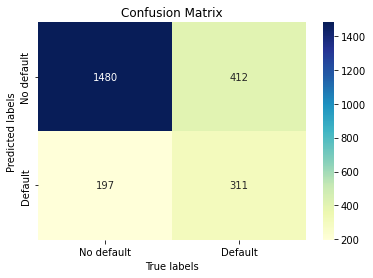

In [162]:
y_pred_upsample, cl_upsample = evaluate_predition_ffnn(model_upsample, 
                                                       X_test, Y_test)

I risultati sono molto simili a quelli ottenuti con il primo modello con un leggero peggioramento in tutte le metriche.

## Random upsample model

In [85]:
# build the model
model_rnd_upsample = build_ffnn_model(X_train_upsample_rnd.shape[1])

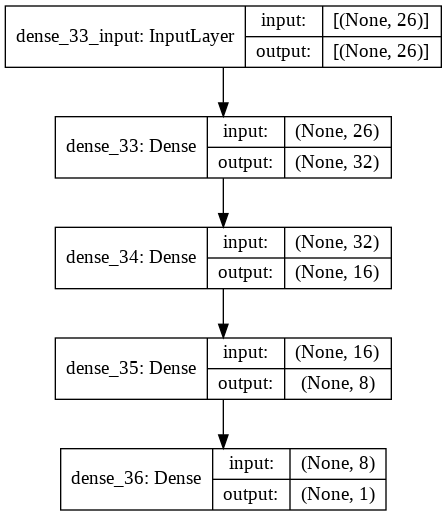

In [192]:
# plotting the model
plot_model(model_rnd_upsample, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [87]:
# same configuration as before 
history_mod_upsample_rnd = training_ffnn(model_rnd_upsample, X_train_upsample_rnd, 
                                     Y_train_upsample_rnd, es)

Epoch 1/100
473/473 - 2s - loss: 0.6632 - accuracy: 0.5877 - val_loss: 0.6343 - val_accuracy: 0.6545
Epoch 2/100
473/473 - 1s - loss: 0.6248 - accuracy: 0.6665 - val_loss: 0.6091 - val_accuracy: 0.6798
Epoch 3/100
473/473 - 1s - loss: 0.6036 - accuracy: 0.6861 - val_loss: 0.5938 - val_accuracy: 0.6836
Epoch 4/100
473/473 - 1s - loss: 0.5923 - accuracy: 0.6945 - val_loss: 0.5865 - val_accuracy: 0.6875
Epoch 5/100
473/473 - 1s - loss: 0.5866 - accuracy: 0.6983 - val_loss: 0.5824 - val_accuracy: 0.6881
Epoch 6/100
473/473 - 1s - loss: 0.5828 - accuracy: 0.6993 - val_loss: 0.5794 - val_accuracy: 0.6950
Epoch 7/100
473/473 - 1s - loss: 0.5801 - accuracy: 0.7003 - val_loss: 0.5771 - val_accuracy: 0.6944
Epoch 8/100
473/473 - 1s - loss: 0.5779 - accuracy: 0.7019 - val_loss: 0.5758 - val_accuracy: 0.6962
Epoch 9/100
473/473 - 1s - loss: 0.5760 - accuracy: 0.7024 - val_loss: 0.5743 - val_accuracy: 0.6962
Epoch 10/100
473/473 - 1s - loss: 0.5742 - accuracy: 0.7026 - val_loss: 0.5734 - val_accura

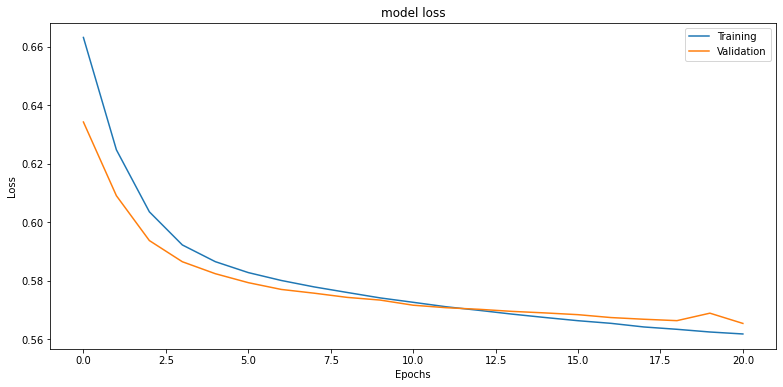

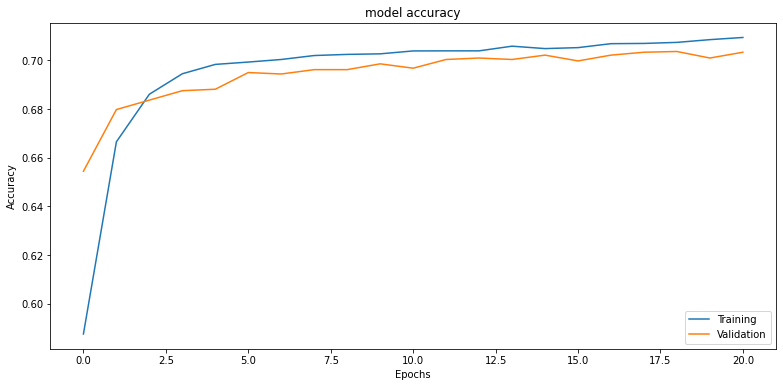

In [88]:
plot_history(history_mod_upsample_rnd)

### Testing random upsample model


Classification Report
               precision    recall  f1-score   support

           0       0.88      0.81      0.85      1892
           1       0.46      0.60      0.52       508

    accuracy                           0.77      2400
   macro avg       0.67      0.71      0.68      2400
weighted avg       0.79      0.77      0.78      2400



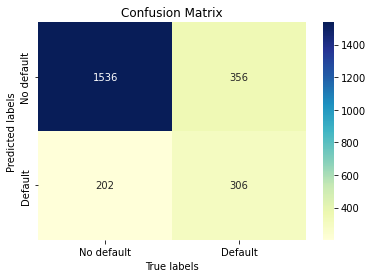

In [163]:
y_pred_upsample_rnd, cl_upsample_rnd = evaluate_predition_ffnn(model_rnd_upsample, 
                                                               X_test, Y_test)

In questo caso valgono tutte le considerazioni già fatte per i precedenti modelli.

## Confronto tra modelli
In questa sezione confronto i 3 modelli per cercare di individuare attraverso l'utilizzo delle metriche quale modello performa meglio sui dati a disposizione. Alcune analisi a livello di under/overfitting sono già state fatte singolarmente nelle sezioni precedenti e non verranno quindi riportate nuovamente.<br>
In prima analisi confronto i 3 modelli con la metrica del `f1_score` della `macro_avg` che media i risultati dell'*f1_score* ottenuti sulla classe 0 ed 1 di predizione. Ho deciso di utilizzare questa metrica invece dell'*accuracy* del modello in quanto la classe 0 viene predetta con molta più precisione della classe 1 che in realtà è molto probabilmente quella di maggior interesse.


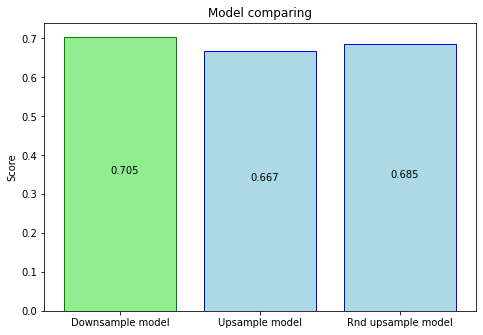

In [169]:
# extract the three macro avg score
macro_avg_downsample = cl_downsample['macro avg']['f1-score']
macro_avg_upsample = cl_upsample['macro avg']['f1-score']
macro_avg_upsample_rnd = cl_upsample_rnd['macro avg']['f1-score']


# bar-plot to compare scores
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Downsample model', 'Upsample model', 'Rnd upsample model']
ax.bar(langs, [macro_avg_downsample, macro_avg_upsample, macro_avg_upsample_rnd],
       color=['lightgreen', 'lightblue', 'lightblue'],  
       edgecolor=['green', 'blue', 'blue'])
ax.set_title('Model comparing')
ax.set_ylabel('Score')

# print value in bar

for pos, val in zip([0,1,2], [macro_avg_downsample, macro_avg_upsample, 
                              macro_avg_upsample_rnd]):
  plt.text(pos-.07, val/2, round(val,3))

plt.show()

Il miglior modello secondo questa metrica risulta essere quello con la tecnica di downsample, inoltre è lo stesso modello che sembrava avere un andamento migliore tra training data e validation data. <br>
Dato che è comunque una media potrebbe essere influenzata da un eventuale valore molto più alto (es. la classe 0 predetta con f-score $= 1$) visualizzo una semplice tabella in cui sia possibile confrontare i singoli f1-score delle due classi, in particolare si preferisce la classe che a parità di score sulla classe 0 abbia uno score alto sulla classe 1.

In [172]:
from prettytable import PrettyTable
t = PrettyTable(['Model', 'Class0_F1', 'Class1_F1'])
t.add_row(['Downsample', cl_downsample['0']['f1-score'], cl_downsample['1']['f1-score']])
t.add_row(['Upsample', cl_upsample['0']['f1-score'], cl_upsample['1']['f1-score']])
t.add_row(['Rnd upsample', cl_upsample_rnd['0']['f1-score'], cl_upsample_rnd['1']['f1-score']])
print(t)

+--------------+--------------------+--------------------+
|    Model     |     Class0_F1      |     Class1_F1      |
+--------------+--------------------+--------------------+
|  Downsample  | 0.8675799086757991 | 0.542246982358403  |
|   Upsample   | 0.8293639674978985 | 0.5052802599512592 |
| Rnd upsample | 0.8462809917355372 | 0.523076923076923  |
+--------------+--------------------+--------------------+


Anche la scomposizione delle metriche restituisce lo stesso risultato, ovvero che il modello con downsample è il migliore anche per la sola classe 1. Tra i modelli con tecnica di upsample sembra migliore quello con tecnica random piuttosto che con SMOTE.

## Prediction
Provo ad effettuare le predizioni su nuove istanze mai viste prima di cui non conosco il reale valore della classe `DEFAULT`. In questa fase uso il primo modello, ovvero quello trainato con downsample, che sembra aver dato miglior risultati secondo la metrica di `macro_avg`. <br>
Per farlo è necessario applicare tutte le stesse trasformazioni fatte sul dataset di training anche al nuovo dataset. <br>

Dalle predizioni mi aspetto un risultato simile a quello ottenuto sul test_set utilizzato in fase di analisi dei modelli in quanto la distribuzione dei dati del test_set dovrebbe essere il più realistica possibile rispetto a dati mai visti. Soprattutto per questo motivo è stato scelto di implementare sia un validation_set, che ha permesso di fermare prima i modelli con la tecnica dell'early_stopping, sia un test set. 

In [174]:
# converting categorical variables

# replace education values
replace_education_values(df_test)
# replace marriage values
replace_marriage_values(df_test)

# get sub dataset with only categorical variabiles (without default coloumn)
df_test_categorical = df_test[categorical_col]
# create df with dummy variables
df_dummy_test = dummy_creation(df_test_categorical)

# drop the old categorical columns from dataset
df_test.drop(categorical_col, axis = 1, inplace=True)
# concat dataset with dummy dataset
df_test = pd.concat([df_test, df_dummy_test], axis = 1)

# drop the unused id column
df_test.drop('ID', axis = 1, inplace = True)
# normalizing with the same scaler
df_test = df_test.astype('float32')
df_test, _ = scaling_variable(df_test, train_scaler)

In [184]:
# make prediction
y_pred = model_downsample.predict(df_test)
y_pred = (y_pred > 0.5)

# converting prediction to int
predictions = [int(obs) for obs in y_pred]

### OPTIONAL - exporting prediction

In [187]:
# write prediction to .txt file
with open("Riccardo_Confalonieri_830404_score2.txt", 'w') as f:
    for item in predictions:
        f.write(str(item)+",\n")

## OPTIONAL: dropout regularization
Come visto nei modelli implementati sin qui è già stata adottata la tecnica di ottimizzazione dell'early_stopping con ripristino dei parametri migliori trovati sino al momento dello stop. Questo si è reso necessario per evitare che i modelli implementati overfittassero troppo i dati come accadeva inizialmente. <br>
In questa sezione si prova ad implementare una tecnica di regolarizzazione diversa, quella del dropout. Dato che questa tecnica viene spesso utilizzata per evitare l'overfitting utilizzo i dati creati con la tecnica di upsample di SMOTE che è quella che sembrava evidenziare un leggero overfitting in precedenza. Ovviamente la tecnica del dropout potrebbe cambiare le analisi fatte in precedenza e quindi potrebbero cambiare i numero di layer/dimensione/iperparametri ottimali per il modello.

In [204]:
# build the model with dropout
model_dropout = build_ffnn_model(X_train_upsample.shape[1], [0.2, 0.1])

# training the model
history_mod_dropout = training_ffnn(model_dropout, X_train_upsample,
                                    Y_train_upsample, es)

Epoch 1/100
473/473 - 2s - loss: 0.6740 - accuracy: 0.5798 - val_loss: 0.6447 - val_accuracy: 0.6268
Epoch 2/100
473/473 - 1s - loss: 0.6389 - accuracy: 0.6365 - val_loss: 0.6202 - val_accuracy: 0.6536
Epoch 3/100
473/473 - 1s - loss: 0.6189 - accuracy: 0.6604 - val_loss: 0.6063 - val_accuracy: 0.6762
Epoch 4/100
473/473 - 1s - loss: 0.6069 - accuracy: 0.6810 - val_loss: 0.5950 - val_accuracy: 0.6923
Epoch 5/100
473/473 - 1s - loss: 0.5959 - accuracy: 0.6909 - val_loss: 0.5880 - val_accuracy: 0.6985
Epoch 6/100
473/473 - 1s - loss: 0.5913 - accuracy: 0.6964 - val_loss: 0.5819 - val_accuracy: 0.7030
Epoch 7/100
473/473 - 1s - loss: 0.5840 - accuracy: 0.7057 - val_loss: 0.5774 - val_accuracy: 0.7063
Epoch 8/100
473/473 - 1s - loss: 0.5796 - accuracy: 0.7082 - val_loss: 0.5726 - val_accuracy: 0.7125
Epoch 9/100
473/473 - 1s - loss: 0.5743 - accuracy: 0.7124 - val_loss: 0.5692 - val_accuracy: 0.7164
Epoch 10/100
473/473 - 1s - loss: 0.5687 - accuracy: 0.7170 - val_loss: 0.5804 - val_accura

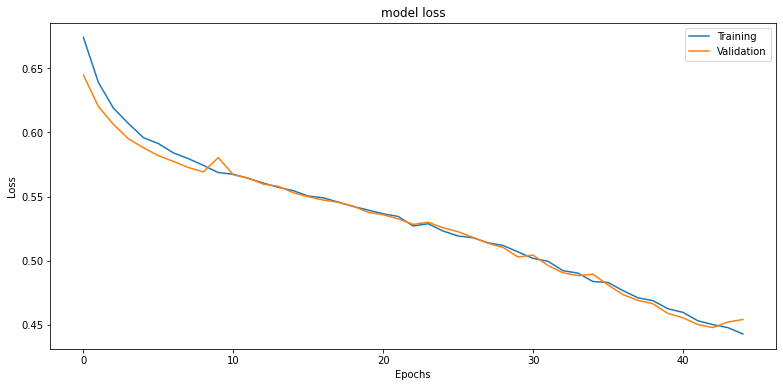

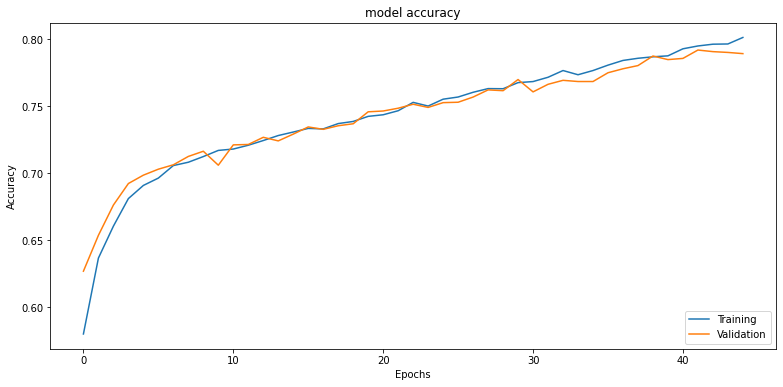

In [205]:
plot_history(history_mod_dropout)

Effettivamente questa tecnica sembra aver **ridotto la problematica dell'overfitting** evidenziata dal modello con upsample. Inoltre anche loss e accuracy sembrano migliorate.
Si segnala inoltre che con questa tecnica sono state **necessarie più epoche** rispetto a prima.


Classification Report
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1892
           1       0.46      0.55      0.50       508

    accuracy                           0.77      2400
   macro avg       0.67      0.69      0.68      2400
weighted avg       0.79      0.77      0.78      2400



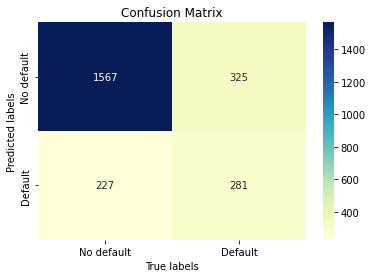

In [206]:
y_pred_dropout, cl_dropout = evaluate_predition_ffnn(model_dropout, X_test, Y_test)

Nonostante il modello sembra aver migliorato le metriche ed essere migliore dei precedenti se si vanno a valutare le stesse metriche sul test set, più simile alla realtà, si nota come non sembra esserci un effettivo miglioramento e il modello con downsample rimane il migliore.

## OPTIONAL: L2 regularization
Provo ad applicare un altro tipo di regolarizzazione, L2, sempre sui dati con upsample.

In [210]:
# For a single-input model with 2 classes (binary classification):
model_l2 = Sequential()
# FC @ 32, non linear
model_l2.add(Dense(32, activation = "relu", input_shape=(X_train_upsample.shape[1],),
                kernel_regularizer=regularizers.l2(0.01), 
                bias_regularizer=regularizers.l2(0.01)))
# FC @ 16, non linear
model_l2.add(Dense(16, activation = "relu",
                   kernel_regularizer=regularizers.l2(0.01), 
                   bias_regularizer=regularizers.l2(0.01)))
# FC @ 8, non linear
model_l2.add(Dense(8, activation = "relu",
                kernel_regularizer=regularizers.l2(0.01), 
                bias_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(1, activation="sigmoid"))

# compile: optimizer & losses/metrics
model_l2.compile(optimizer = SGD(), loss = "binary_crossentropy", 
              metrics = ["accuracy"])
  

In [211]:
# training the model
model_l2_history = training_ffnn(model_l2, X_train_upsample, Y_train_upsample, es)

Epoch 1/100
473/473 - 2s - loss: 1.2228 - accuracy: 0.6046 - val_loss: 1.1507 - val_accuracy: 0.6431
Epoch 2/100
473/473 - 1s - loss: 1.0929 - accuracy: 0.6678 - val_loss: 1.0451 - val_accuracy: 0.6699
Epoch 3/100
473/473 - 1s - loss: 0.9985 - accuracy: 0.6880 - val_loss: 0.9649 - val_accuracy: 0.6932
Epoch 4/100
473/473 - 1s - loss: 0.9237 - accuracy: 0.7021 - val_loss: 0.8989 - val_accuracy: 0.6994
Epoch 5/100
473/473 - 1s - loss: 0.8622 - accuracy: 0.7103 - val_loss: 0.8469 - val_accuracy: 0.6968
Epoch 6/100
473/473 - 1s - loss: 0.8131 - accuracy: 0.7151 - val_loss: 0.8043 - val_accuracy: 0.6979
Epoch 7/100
473/473 - 1s - loss: 0.7734 - accuracy: 0.7202 - val_loss: 0.7687 - val_accuracy: 0.7027
Epoch 8/100
473/473 - 1s - loss: 0.7404 - accuracy: 0.7245 - val_loss: 0.7372 - val_accuracy: 0.7176
Epoch 9/100
473/473 - 1s - loss: 0.7131 - accuracy: 0.7287 - val_loss: 0.7144 - val_accuracy: 0.7108
Epoch 10/100
473/473 - 1s - loss: 0.6907 - accuracy: 0.7311 - val_loss: 0.6942 - val_accura

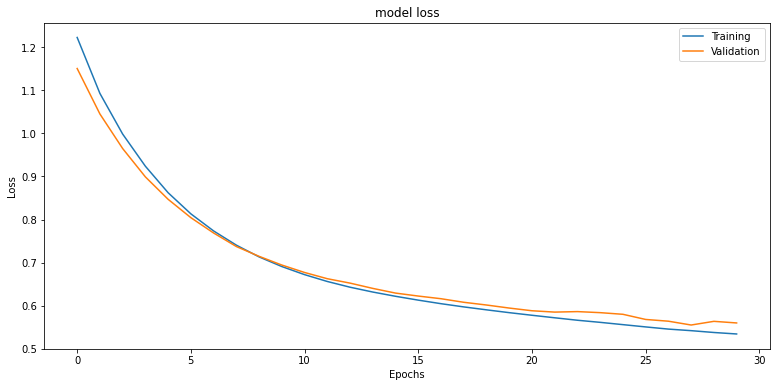

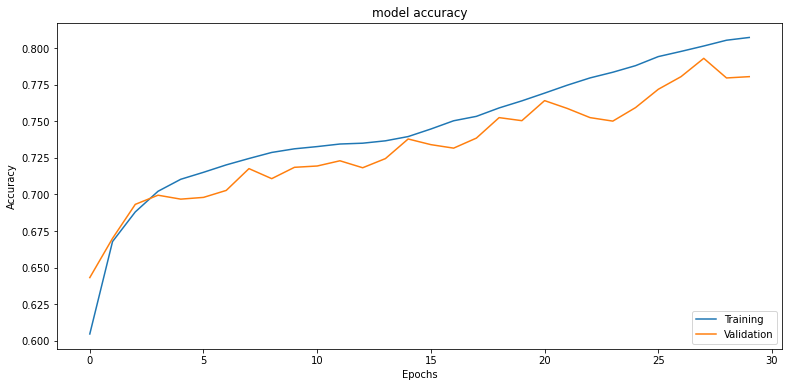

In [214]:
plot_history(model_l2_history)


Classification Report
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      1892
           1       0.52      0.55      0.53       508

    accuracy                           0.80      2400
   macro avg       0.70      0.70      0.70      2400
weighted avg       0.80      0.80      0.80      2400



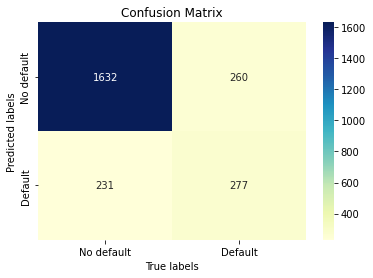

In [213]:
y_pred_l2, cl_l2 = evaluate_predition_ffnn(model_l2, X_test, Y_test)

Anche questa regolarizzazione è riuscita a risolvere la problematica dell'overfitting presentatasi in precedenza anche se in maniera leggermente meno marcata rispetto al dropout.
Le metriche di test in questo caso risultano essere identiche a quelle ottenute con la tecnica di downsampling con un macro_avg $= 0.70$ e anche a livello di singolo f1-score sulle classi si sono ottenuti gli stessi score.

## Future improvement
Come analizzato il modello performa molto bene sulla classe 0 che però, con molta probabilità, è quella che meno interessa a livello di analisi. Si è infatti più interessati a predire con precedenza la classe 1 che riporta gli utenti a rischio default. In tal senso si potrebbe provare a cambiare il tipo di feature utilizzate creandone di più rilevanti, come visto in fase di ispezione dei dati molte features sono correlate tra loro. <br>
Inoltre si segnala che per provare a migliorare la predizione della classe 1 sono state effettaute prove con diversi tipi di scaler per i dati e anche riducendo il numero di features in modo motlo semplice andando a selezionare soltanto quelle che sembravano avere più correlazione con il default.